<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.Spaceship-Titanic/blob/main/1_data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is dedicated to exploring the training dataset

# Imports

In [1]:
# google drive
from google.colab import drive

# data
import pandas as pd

# math
import numpy as np

# plotting
import matplotlib.pyplot as plt

## PEP8 code standard

In [2]:
# PEP 8 
%%capture 
!pip install pycodestyle 
!pip install --index-url https://test.pypi.org/simple/ nbpep8 

from nbpep8.nbpep8 import pep8

## Importing custom packages

In [35]:
%%capture
def download_files(url_dict):
    for file, url in url_dict.items():
        print(f'Downloading {file}')
        !wget -O {file} {url} {file}

git_download_path = \
'https://raw.githubusercontent.com/PashaIanko/Kaggle.Spaceship-Titanic/main/'

files = [
    'path_manager.py',
    'sklearn_transformers.py',
    'sklearn_utils.py'
]

url_dict = {file: git_download_path + file for file in files}
download_files(url_dict)

pep8(_ih)

In [36]:
import importlib
import path_manager
import sklearn_utils

def reload_all(modules_list_):
    for module in modules_list_:
        importlib.reload(module)

reload_all(
    [
        path_manager,
        # other modules
    ]
)

from path_manager import PathManager
from sklearn_utils import (
    nan_statistics,
    visualize_datasets_distributions
)

# Set up paths

In [5]:
drive.mount('/content/gdrive', force_remount=True)
gdrive_path = '/content/gdrive/MyDrive/'

PREPROC_TRIAL = 1
MODELS_TRIAL = 1
COMPETITION_PATH = gdrive_path + 'ML/Competitions/6.SpaceshipTitanic/'

manager = PathManager(
    competition_path=COMPETITION_PATH,
    preprocessing_trial=PREPROC_TRIAL,
    models_trial=MODELS_TRIAL
)
manager.setup_paths()

Mounted at /content/gdrive
/content/gdrive/MyDrive/ML/Competitions/6.SpaceshipTitanic/Data/preproc_trial_1 already exists
/content/gdrive/MyDrive/ML/Competitions/6.SpaceshipTitanic/Models/trial_1 already exists


# Frame the problem

1. Type of task?
	- Supervised learning
	- Classification
	- Batch learning (not online)
2. How company will benefit from task? How model will be used?
    - *To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.*
3. Algorithms?
    - Log regression baseline
    - FFNN
    - Random forest
    - SVM classification
4. Performance measure?
    - Cross entropy loss for binary classification
    - F1 metrics for performance (check the class balance)
5. Domain knowledge?
    - None
6. What the current solution looks like (if any)?
    - No current solution
7. Are there hypotheses to build? (Before looking at the data!)
    - None

# Download the data

In [6]:
manager.train_path

'/content/gdrive/MyDrive/ML/Competitions/6.SpaceshipTitanic/Data/train.csv'

In [7]:
df_test = pd.read_csv(manager.test_path)

df_train = pd.read_csv(manager.train_path)
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [8]:
train_cols = set(df_train.columns)
test_cols = set(df_test.columns)

assert train_cols - test_cols == {'Transported'}

# Quick look at the data (conclusions are described in journal)

In [9]:
from sklearn_utils import nan_statistics

_ = nan_statistics(df_train)

Col -- Nan percentage
CryoSleep 2.4962613597147127
ShoppingMall 2.392729782583688
VIP 2.3352122397331185
HomePlanet 2.312205222592891
Name 2.300701714022777
Cabin 2.289198205452663
VRDeck 2.1626596111814105
FoodCourt 2.105142068330841
Spa 2.105142068330841
Destination 2.093638559760727
RoomService 2.082135051190613
Age 2.0591280340503855


In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [11]:
df_train.fillna(0).describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000
mean,28.234326,220.009318,448.434027,169.572300,304.588865,298.261820
std,14.912090,660.519050,1595.790627,598.007164,1125.562559,1134.126417
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,37.000000,41.000000,61.000000,22.000000,53.000000,40.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


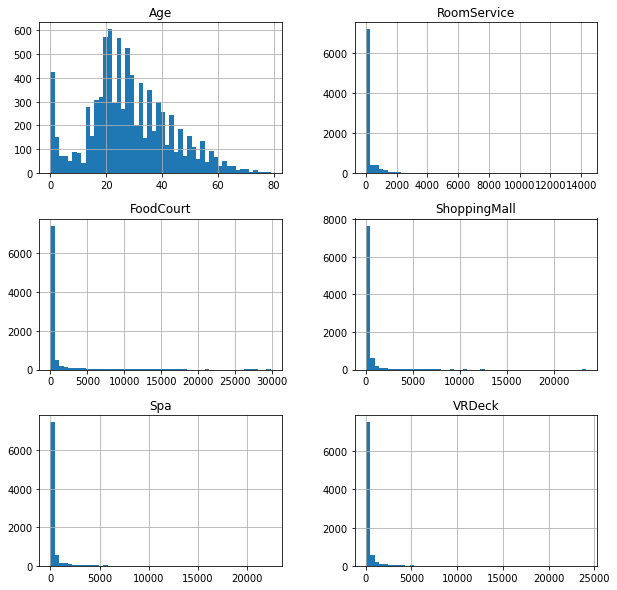

In [12]:
_ = df_train.\
    fillna(0, inplace=False).\
    hist(bins=50, figsize=(10, 10))

## Class balance

As we see below, the training dataset is perfectly balanced

In [13]:
df_train['Transported'].value_counts() / df_train.shape[0]

True     0.503624
False    0.496376
Name: Transported, dtype: float64

## Are train and test features similarly distributed?

In [ ]:
visualize_datasets_distributions(
    {
        'trainval': df_train,
        'test': df_test,
    },
    list(
        df_test.columns[df_test.dtypes == 'float64']
    ),
    grid_width_=2,
    figwidth_=10
)

TypeError: ignored

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7ff44cd1f710> (for post_execute):


KeyboardInterrupt: ignored